In [18]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns

sns.set_style('darkgrid')

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [19]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-04-26 17:17:45--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-26 17:17:46 (57.1 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [20]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [21]:
# Walk through each directory
dataset = "../input/100-bird-species/train"

In [22]:
train_dir = Path('../input/100-bird-species/train')
val_dir = Path('../input/100-bird-species/valid')
test_dir = Path('../input/100-bird-species/test')
from pathlib import Path
train_image_count = len(list(train_dir.glob('**/*.jpg')))
train_image_count

84635

In [23]:
batch_size = 32
image_width = 224
image_height = 224

train_ds = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    val_dir,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

test_ds = keras.preprocessing.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(image_height, image_width),
    batch_size=batch_size
)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


In [24]:
#check data class
class_names = train_ds.class_names 
class_names

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN DIPPER',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMERICAN ROBIN',
 'AMERICAN WIGEON',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY STORM PETREL',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'ASIAN DOLLARD BIRD',
 'ASIAN GREEN BEE EATER',
 'ASIAN OPENBILL STORK',
 'AUCKLAND SHAQ',
 'AUSTRAL CANASTERO',
 'AUSTRALASIAN FIGBIRD',
 'AVADAVAT',
 'AZARAS SPINETAIL',
 'AZURE 

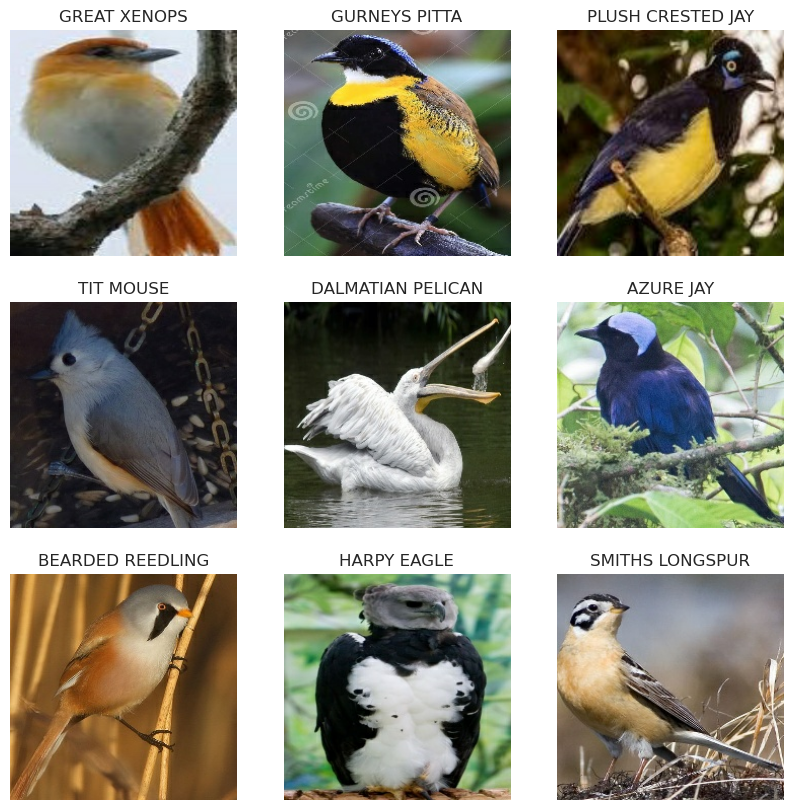

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [26]:
base_model = keras.applications.MobileNetV3Small(input_shape=(image_width, image_height, 3),
                                            classes=525,
                                            include_top=False,
                                            weights='imagenet')

In [27]:
# Freeze convolutional base
base_model.trainable = False
base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                   

In [29]:
data_augmentation = keras.models.Sequential([
  keras.layers.RandomFlip('horizontal'),
  keras.layers.RandomRotation(0.2)
])

In [31]:
num_classes = len(class_names)
inputs = keras.Input(shape=(image_width, image_height, 3))
x = data_augmentation(inputs)

x = keras.applications.mobilenet_v3.preprocess_input(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)


outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [32]:
#compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d_2   (None, 576)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 576)               0         
                                                                 
 dense_2 (Dense)             (None, 525)               302925    
                                                                 
Total params: 1,242,045
Trainable params: 302,925
Non-train

In [33]:
#fitting model
initial_epochs = 10

early_stop = keras.callbacks.EarlyStopping(patience=1, restore_best_weights=True)

history = model.fit(train_ds, 
          validation_data=val_ds,
          epochs=initial_epochs,
          callbacks=[early_stop])

Epoch 1/10
2645/2645 [==============================] - 109s 40ms/step - loss: 1.7159 - accuracy: 0.6715 - val_loss: 0.5322 - val_accuracy: 0.8952
Epoch 2/10
2645/2645 [==============================] - 105s 40ms/step - loss: 0.6458 - accuracy: 0.8501 - val_loss: 0.3626 - val_accuracy: 0.9223
Epoch 3/10
2645/2645 [==============================] - 114s 43ms/step - loss: 0.4949 - accuracy: 0.8786 - val_loss: 0.3145 - val_accuracy: 0.9250
Epoch 4/10
2645/2645 [==============================] - 113s 43ms/step - loss: 0.4109 - accuracy: 0.8952 - val_loss: 0.2910 - val_accuracy: 0.9261
Epoch 5/10
2645/2645 [==============================] - 120s 45ms/step - loss: 0.3625 - accuracy: 0.9046 - val_loss: 0.2662 - val_accuracy: 0.9349
Epoch 6/10
2645/2645 [==============================] - 114s 43ms/step - loss: 0.3267 - accuracy: 0.9131 - val_loss: 0.2613 - val_accuracy: 0.9322
Epoch 7/10
2645/2645 [==============================] - 119s 45ms/step - loss: 0.3003 - accuracy: 0.9179 - val_loss: 0

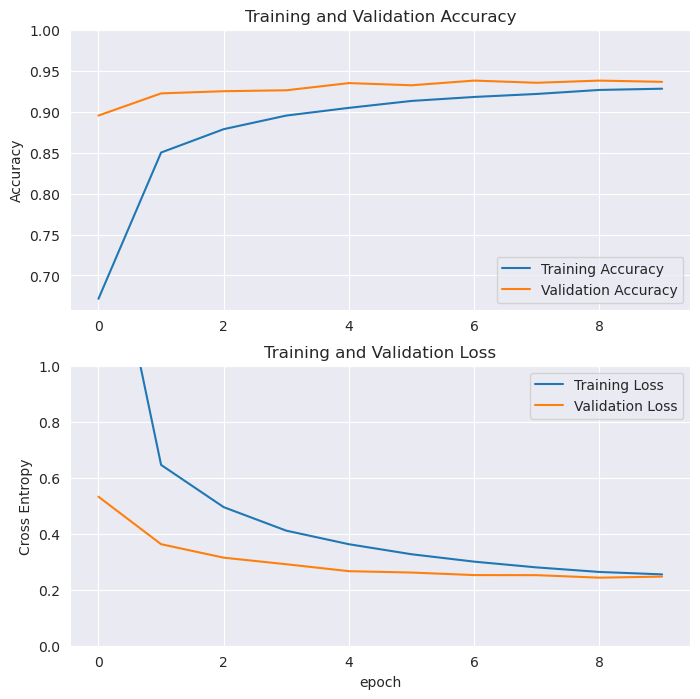

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 1s 878ms/step


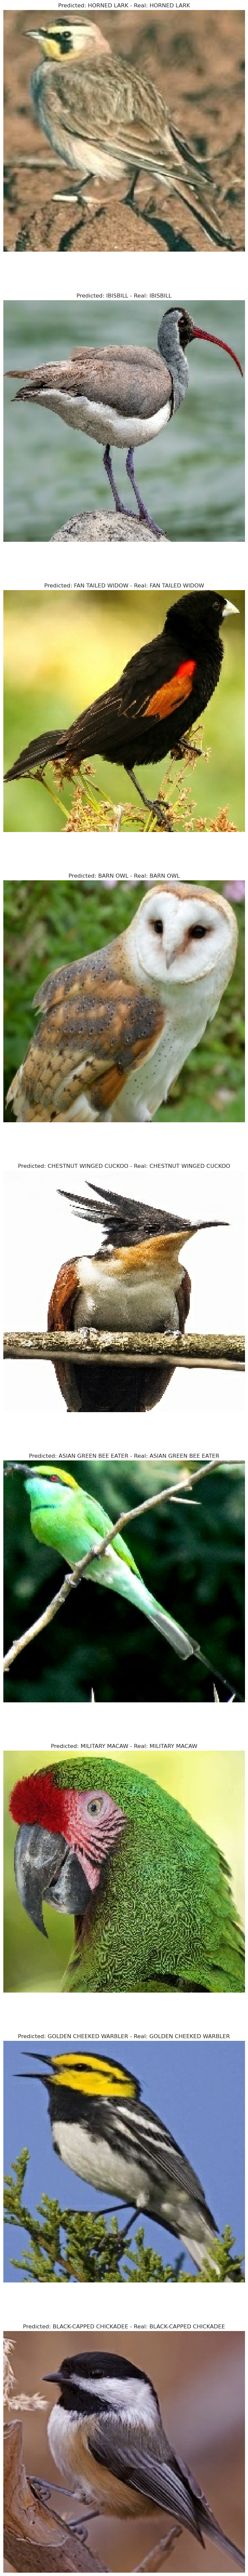

In [35]:
plt.figure(figsize=(10, 100))
for images, labels in test_ds.take(1):
    prediction = model.predict(images,batch_size=32)
    for i in range(9):
        ax = plt.subplot(9, 1, i+1)
        pred = np.argmax(prediction[i])
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f'Predicted: {class_names[pred]} - Real: {class_names[labels[i]]}')
        plt.axis('off')

In [37]:
#Visualize the result
results = model.evaluate(test_ds, verbose=0)

In [38]:
print(" ## Test Loss: {:.5f}".format(results[0]))
print(" ## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

 ## Test Loss: 0.16714
 ## Accuracy on the test set: 95.09%


In [39]:
test_ds_unbatch = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed=None,
    shuffle=False,
    image_size=(image_height, image_width),
    batch_size=image_height,
)
images = list(test_ds_unbatch.map(lambda x, y: x))
labels = list(test_ds_unbatch.map(lambda x, y: y))

Found 2625 files belonging to 525 classes.


In [40]:
y_test = np.concatenate([y for x, y in test_ds_unbatch], axis=0)
prediction = model.predict(test_ds_unbatch)
pred = np.argmax(prediction,axis=1)
print(pred)    
from sklearn.metrics import accuracy_score

accuracy_score(pred,y_test)

12/12 [==============================] - 5s 278ms/step
[  0  47   0 ... 524 524 524]


0.9508571428571428

In [41]:
# Save the model to a file
model.save('classify-bird-species-525.h5')

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Make predictions on test data
y_pred = np.argmax(model.predict(test_ds_unbatch), axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_ds_unbatch], axis=0)

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Calculate precision
precision = precision_score(y_true, y_pred, average='macro')

# Calculate recall
recall = recall_score(y_true, y_pred, average='macro')

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='macro')

# Calculate AUC-ROC
probs = model.predict(test_ds_unbatch)
auc_roc = roc_auc_score(y_true, probs, multi_class='ovr')

# Print the performance metrics
print('Accuracy: %.3f' % accuracy)
print('Precision: %.3f' % precision)
print('Recall: %.3f' % recall)
print('F1 Score: %.3f' % f1)
print('AUC-ROC: %.3f' % auc_roc)

12/12 [==============================] - 3s 277ms/step
Accuracy: 0.951
Precision: 0.961
Recall: 0.951
F1 Score: 0.949
AUC-ROC: 1.000


In [50]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from sklearn.metrics import cohen_kappa_score


# Calculate confusion matrix
y_pred = np.argmax(model.predict(test_ds_unbatch), axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:\n', conf_matrix)

# Calculate classification report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report:\n', class_report)

# Calculate Cohen's Kappa
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa:", kappa)

12/12 [==============================] - 3s 276ms/step
Confusion Matrix:
 [[4 0 0 ... 0 0 0]
 [0 3 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 4 0]
 [0 0 0 ... 0 0 4]]
Classification Report:
                                precision    recall  f1-score   support

              ABBOTTS BABBLER       1.00      0.80      0.89         5
                ABBOTTS BOOBY       1.00      0.60      0.75         5
   ABYSSINIAN GROUND HORNBILL       1.00      1.00      1.00         5
        AFRICAN CROWNED CRANE       1.00      1.00      1.00         5
       AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
            AFRICAN FIREFINCH       1.00      1.00      1.00         5
       AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
        AFRICAN PIED HORNBILL       1.00      0.80      0.89         5
          AFRICAN PYGMY GOOSE       1.00      1.00      1.00         5
                    ALBATROSS       1.00      1.00      1.00         5
